#  Introduction

This notebook is aimed at helping people learn about creating Convolutional Neural Networks (ConvNets) in [Julia](http://julialang.org/) using [MXNet](http://mxnet.io/), specifically the Julia interface [MXNet.jl](http://github.com/dmlc/MXNet.jl). 

It assumes a basic knowledge of Julia as well as supervised machine learning principles such as training vs eval and test sets.  It follows a [previous notebook](https://github.com/ultradian/julia_notebooks/blob/master/mnistMLP.ipynb) on using Multi Layer Perceptron to identify MNIST characters with MXNet.  There is some overlap, but you should know everything in the previous notebook before exploring this one.  In particular, we will be using the same dataset, but I will not be reviewing any of the information on the background of the data or details of its processing besides around its use in ConvNets.

Data is obtained from https://www.kaggle.com/c/digit-recognizer/data and assumed to be in a `data` folder. Files are named `train.csv` and `test.csv`.  

# Check data

In [1]:
using DataFrames

In [2]:
# read in data
@time train = readtable("data/train.csv");

 12.286511 seconds (35.65 M allocations: 1.177 GB, 2.60% gc time)


In [3]:
using Plots
pyplot()

Plots.PyPlotBackend()


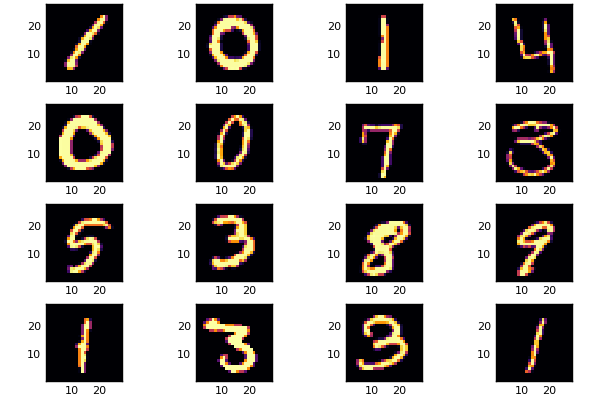

In [4]:
# take a quick look with Plots
plot([heatmap(rotl90(reshape(Array(train[i,2:end]), 28, 28)), aspect_ratio=:equal, legend=false) for i=1:16]...)


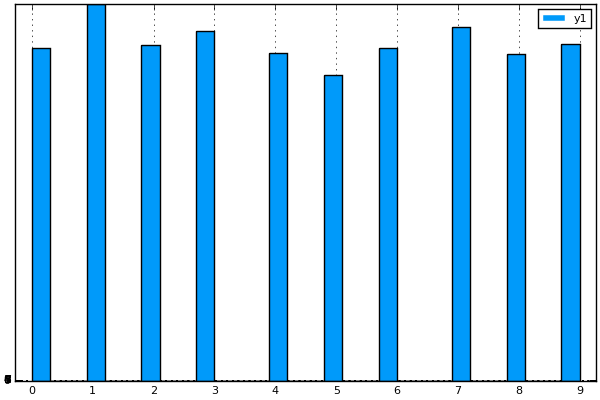

In [5]:
histogram(train[:label], ticks=collect(0:9))

# Prepare data

In [6]:
# separate out labels
X = transpose(Array(train[:,2:end]))
y = Array(train[:,1])

42000-element Array{Int64,1}:
 1
 0
 1
 4
 0
 0
 7
 3
 5
 3
 8
 9
 1
 ⋮
 0
 5
 3
 1
 9
 6
 4
 0
 1
 7
 6
 9

In [7]:
N = size(X)[2]

42000

In [8]:
extrema(X)

(0,255)

In [9]:
mean(X)

33.408911169825075

In [10]:
var(X)

6190.186921854022

In [11]:
# scale X to get variance around one
X = X./80;

In [12]:
var(X)

0.9672167065396925

In [13]:
mean(X)

0.41761138962281336

In [14]:
# shift X to get mean close to zero
X = X.-0.4176;

# Split data

In [15]:
# mx.Convolution() method requires data in a 4D tensor
X = reshape(X, 28,28,1,N)

28×28×1×42000 Array{Float64,4}:
[:, :, 1, 1] =
 -0.4176  -0.4176  -0.4176  -0.4176  …  -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176  …  -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176  …  -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4

In [16]:
# split the train data into a training set (cv_X) and an eval set (eval_X)
split = 0.8
cv_X = X[:,:,:,1:floor(Int,split*N)]
eval_X = X[:,:,:,floor(Int,split*N)+1:N]

28×28×1×8400 Array{Float64,4}:
[:, :, 1, 1] =
 -0.4176  -0.4176  -0.4176  -0.4176  …  -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176  …  -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176  …  -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.41

In [17]:
cv_y = y[1:floor(Int,split*N)]
eval_y = y[floor(Int,split*N)+1:N]

8400-element Array{Int64,1}:
 0
 7
 7
 2
 2
 6
 5
 7
 8
 5
 3
 0
 2
 ⋮
 0
 5
 3
 1
 9
 6
 4
 0
 1
 7
 6
 9

# Setup providers

In [18]:
using MXNet

In [19]:
batch_size = 1000

1000

In [20]:
train_provider = mx.ArrayDataProvider(cv_X, cv_y, batch_size=batch_size, shuffle=true)

MXNet.mx.ArrayDataProvider(Array{Float32,N}[
Float32[-0.4176 -0.4176 … -0.4176 -0.4176; -0.4176 -0.4176 … -0.4176 -0.4176; … ; -0.4176 -0.4176 … -0.4176 -0.4176; -0.4176 -0.4176 … -0.4176 -0.4176]],Symbol[:data],Array{Float32,N}[
Float32[1.0 0.0 … 2.0 2.0]],Symbol[:softmax_label],1000,33600,true,0.0f0,0.0f0,MXNet.mx.NDArray[mx.NDArray{Float32}(28,28,1,1000)],MXNet.mx.NDArray[mx.NDArray{Float32}(1000,)])

In [21]:
eval_provider = mx.ArrayDataProvider(eval_X, eval_y, batch_size=batch_size, shuffle=false)

MXNet.mx.ArrayDataProvider(Array{Float32,N}[
Float32[-0.4176 -0.4176 … -0.4176 -0.4176; -0.4176 -0.4176 … -0.4176 -0.4176; … ; -0.4176 -0.4176 … -0.4176 -0.4176; -0.4176 -0.4176 … -0.4176 -0.4176]],Symbol[:data],Array{Float32,N}[
Float32[0.0 7.0 … 6.0 9.0]],Symbol[:softmax_label],1000,8400,false,0.0f0,0.0f0,MXNet.mx.NDArray[mx.NDArray{Float32}(28,28,1,1000)],MXNet.mx.NDArray[mx.NDArray{Float32}(1000,)])

# Setup model 

Like the [previous MLP model](mnistMLP.ipynb#MLP), we will set up a `SymbolicNode` with data input with the `mx.Variable()` method and an output layer with `mx.SoftmaxOutput()` that is fed from a `mx.FullyConnected()` layer with 10 nodes to represent the 10 digits.  What differs will be the addition of `Convolution` and `Pooling` layers.  

This model is loosely based on the famous LeNet5 network described in LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278-2324.  The article is available on ResearchGate at https://www.researchgate.net/profile/Yann_Lecun/publication/2985446_Gradient-based_learning_applied_to_document_recognition/links/0deec519dfa1983fc2000000/Gradient-based-learning-applied-to-document-recognition.pdf.  

Each convolutional layer is composed of a set of *feature maps* which each of which is extracted from the input layer by a corresponding set of *filter banks* which store the corresponding set of trainable weights and bias.  The filters will be convolved over the input layer during feedforward, creating the activation map for the next layer.  In order to reduce the effect of small variations in input to the feature detector, the next layer is usually a *pooling layer* which 'coarsens' and reduces the size of the activation map using some particular function such as averaging values in a sub-region (average pooling), or selecting the maximum value in the sub-region (max pooling), or even functions like L2-norm pooling.

In the original model (see the image below from the LeCun paper), the network uses a 5x5 kernel which makes 25 trainable weights plus one bias.  There are 6 filters of this type to create 6 feature maps.  Note that the size of the feature map is smaller than te input because running a 5x5 kernel over a rectangular input will produce 4 less results in each direction.  Also note that the 'subsampling' layers reduce the size by half as they take a 2x2 neighborhood and reduce it to a single value.

![](https://www.researchgate.net/profile/Haohan_Wang/publication/282997080/figure/fig10/AS:305939199610894@1449952997905/Figure-10-Architecture-of-LeNet-5-one-of-the-first-initial-architectures-of-CNN.png)

There are a lot of differences between our model and the original LeNet5.  These include:
* the original increased the size of images to 32x32 to make sure there was better centering for the feature maps
* the original 'subsampled' by adding the four values, then applying the 'squashing' activation
* input to the second convolution layer were specifically tailored to select a fixed distribution of patterns from the previous layer; we are just letting backprop do the work
* the original used an Euclidean Radial Basis Function for output that was calculated from a 84 node layer which in turn corresponded to vectors derived from ASCII characters drawn on a 7x12 bitmap. We are using just making a single layer MLP with softmax

The original LeNet5 reported an error rate on the test set of 0.95%.  An earlier version LeNet4 got an error rate of 1.1% using 4 feature maps in the first convolutional layer, creating pairs to get 8 subsampling maps, then 16 feature maps in the second convolutional layer. 

We are going to use the same kernel size on a 28x28 image, halving the result by using a max pooling layer.  When I tried this with 6 filters in the first convolutional layer and 16 in the second, I got a maximum of 75% accuracy, so we are going to increase the number of filters although this increases the memory demand and computation time.

Clearly the fine tuning done by LeCun et al. helped make their network more efficient.

In [22]:
# set up net
data = mx.Variable(:data)
# first conv, takes 28x28 -> 24x24 (with convolution) -> 12x12 (with max pooling)
conv1 = @mx.chain mx.Convolution(data, kernel=(5,5), num_filter=12, name=:conv1)  =>
 mx.Activation(act_type=:tanh) =>
 mx.Pooling(pool_type=:max, kernel=(2,2), stride=(2,2))
# second conv, takes 12x12 -> 8x8 -> 4x4
conv2 = @mx.chain mx.Convolution(conv1, kernel=(5,5), num_filter=25, name=:conv2) =>
 mx.Activation(act_type=:tanh) =>
 mx.Pooling(pool_type=:max, kernel=(2,2), stride=(2,2))
# fully-connected
fc   = @mx.chain mx.Flatten(conv2) =>
 mx.FullyConnected(name=:fc1, num_hidden=100) =>
 mx.Activation(name=:relu1, act_type=:tanh) =>
 mx.FullyConnected(name=:fc2, num_hidden=10) 
# softmax loss
lenet = mx.SoftmaxOutput(fc, name=:softmax)

MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x00000000186b58a0))

In [23]:
# change context to gpu(number) if you have a gpu
model = mx.FeedForward(lenet, context=mx.cpu())

MXNet.mx.FeedForward(MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x00000000186b58a0)),MXNet.mx.Context[CPU0],#undef,#undef,#undef)

In [24]:
optimizer = mx.SGD(lr=0.05, momentum=0.9, weight_decay=0.00001)

MXNet.mx.SGD(MXNet.mx.SGDOptions(0.05,0.9,0,1.0e-5,MXNet.mx.LearningRate.Fixed(0.05),MXNet.mx.Momentum.Fixed(0.9)),#undef)

In [25]:
# run one epoch and then check initial states
@time mx.fit(model, optimizer, train_provider, eval_data=eval_provider, n_epoch=1)

INFO: Start training on MXNet.mx.Context[CPU0]
INFO: Initializing parameters...
INFO: Creating KVStore...
INFO: TempSpace: Total 69 MB allocated on CPU0
INFO: Start training...
INFO: == Epoch 001/001 ==========
INFO: ## Training summary
INFO:           accuracy = 0.1071


 48.788478 seconds (8.52 M allocations: 582.540 MB, 1.20% gc time)


INFO:               time = 37.3494 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.1056
INFO: Finish training on MXNet.mx.Context[CPU0]


In [26]:
# see parameters of model
model.arg_params

Dict{Symbol,MXNet.mx.NDArray} with 8 entries:
  :fc1_weight   => mx.NDArray{Float32}(400,100)
  :fc1_bias     => mx.NDArray{Float32}(100,)
  :conv1_bias   => mx.NDArray{Float32}(12,)
  :fc2_weight   => mx.NDArray{Float32}(100,10)
  :conv2_bias   => mx.NDArray{Float32}(25,)
  :conv1_weight => mx.NDArray{Float32}(5,5,1,12)
  :conv2_weight => mx.NDArray{Float32}(5,5,12,25)
  :fc2_bias     => mx.NDArray{Float32}(10,)

In [27]:
# let's examine the weights conv1
c1 = copy(model.arg_params[:conv1_weight])

5×5×1×12 Array{Float32,4}:
[:, :, 1, 1] =
  0.00512531   0.00837125    0.00281091   0.00846626   0.00643019
  0.00799078   0.000818736   0.00515521  -0.00554994   0.00958022
 -0.00426324  -0.00921843    0.00122458  -0.00577868  -0.00240331
  0.00315924   0.00685352    0.00176617  -0.00818752  -0.0049658 
  0.00358987  -0.00245411   -0.00413707  -1.79939f-5  -0.00154833

[:, :, 1, 2] =
  0.000763565   0.00313066   0.00229768   0.00369832   -0.00423609
  0.0089124    -0.00582938   0.00395531  -0.00388271    0.00296551
  0.00232113   -0.00242816  -0.00439619  -0.000979142  -0.00244067
 -0.00591004   -0.00441763  -0.00894152  -0.00580061    0.00256294
  0.00123639   -0.0100695    0.00694906   0.00212107   -0.00733337

[:, :, 1, 3] =
 -0.000152781  0.00472325   0.00345742   0.00448248  -0.00936355
 -0.00291785   0.00492393   0.00687924  -0.00894543  -0.00933406
  0.0071224    0.00451441   0.0051955    0.00925095   0.00513764
  0.00518424   0.00854222  -0.00730659  -0.00124098  -0.0036685 
 

In [28]:
# let's get the extrema mean and standard deviation for each of the 6 groups
[ [extrema(c1[:,:,1,i]) for i in 1:12] [mean(c1[:,:,1,i]) for i in 1:12] [std(c1[:,:,1,i]) for i in 1:12] ]

12×3 Array{Any,2}:
 (-0.00921843,0.00958022)   0.000912714  0.00556829
 (-0.0100695,0.0089124)    -0.00103004   0.00498044
 (-0.00936355,0.00925095)   0.00123669   0.00584952
 (-0.00840176,0.00972395)   0.00248337   0.00634553
 (-0.00974625,0.00963116)   8.31934f-5   0.00651995
 (-0.0101928,0.00848661)   -0.00219653   0.00557281
 (-0.0102169,0.00908446)   -0.00103776   0.00631654
 (-0.00951762,0.0098016)    0.000588509  0.00687461
 (-0.00786816,0.0097468)    0.00124341   0.00604047
 (-0.00957229,0.00922874)   0.000807526  0.00604569
 (-0.0098571,0.00999337)   -0.00113546   0.00614295
 (-0.00897417,0.00934937)   0.00199932   0.00641252

In [29]:
# let's also get the extrema mean and standard deviation for all
[ extrema(c1[:,:,1,:]) mean(c1[:,:,1,:]) std(c1[:,:,1,:]) ]

1×3 Array{Any,2}:
 (-0.0102169,0.00999337)  0.000329578  0.006115


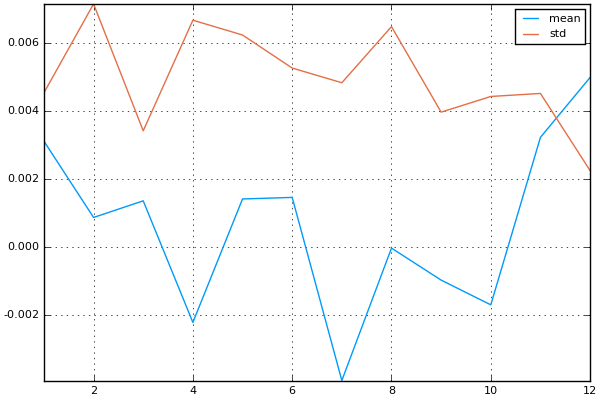

In [30]:
# plot mean and std
plot([ [mean(c1[:,i]) for i in 1:12] [std(c1[:,i]) for i in 1:12] ], legend=true, label=["mean" "std"])


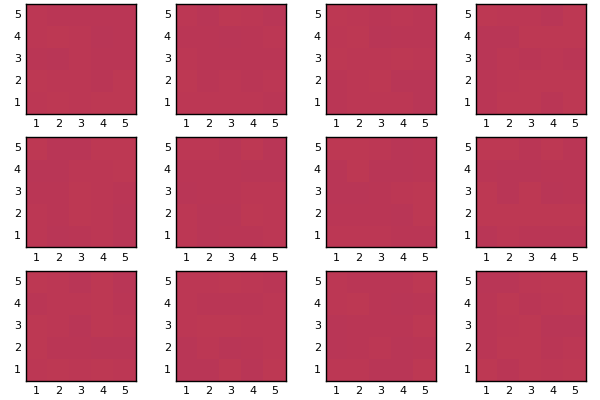

In [31]:
# plot them as 5x5 arrays
plot([heatmap(c1[:,:,1,i], aspect_ratio=:equal, legend=false, clims=(-0.8,0.8)) for i=1:12]...)

In [32]:
# let's examine the weights conv2 as well
c2 = copy(model.arg_params[:conv2_weight])

5×5×12×25 Array{Float32,4}:
[:, :, 1, 1] =
  0.00263548  -0.00232051  -0.00332369   0.00994321    0.00910522 
 -0.0078545    0.00372002   0.00301441   0.00874926   -0.000303656
  0.00777481  -0.00601126   0.00540698  -0.0101059    -0.00362756 
  0.00884586  -0.00132411   0.00823333   0.00920554    0.00595989 
  0.00282404  -0.00108938  -0.0061495    0.000103228  -0.0081785  

[:, :, 2, 1] =
 -0.00641282  -0.00357876   0.00371893  -0.00689439  -0.00898872
 -0.00780511  -0.00366582   0.00764735   0.00814971   0.00793213
 -0.0030671   -0.00977768   0.00369416   0.00404513  -0.00549631
  0.00399083  -0.006892    -0.00165321   0.00460487  -0.00395965
 -0.00823981  -0.00494667  -0.00899112   0.00752334   0.00408806

[:, :, 3, 1] =
 -0.00211547   -0.000894217   0.00749082    0.00887346  -0.00703745
  0.00918151   -0.00969768    0.000798331  -0.00894032  -0.00143501
  0.000339759   0.00346509   -0.00597923   -0.01001     -3.16835f-5
 -0.00446473   -0.00755168    0.00705959   -0.00971083   0.00

In [33]:
# let's get the extrema mean and standard deviation for each of the 25 groups
[ [extrema(c2[:,:,1,i]) for i in 1:25] [mean(c2[:,:,1,i]) for i in 1:25] [std(c2[:,:,1,i]) for i in 1:25] ]

25×3 Array{Any,2}:
 (-0.0101059,0.00994321)    0.00140931   0.00625763
 (-0.00934711,0.0096927)   -0.00048369   0.00631852
 (-0.00705308,0.00984313)   0.00140912   0.00537561
 (-0.00973851,0.0093068)    0.00175645   0.00574958
 (-0.00924821,0.00964155)   5.49718f-5   0.00640251
 (-0.00985153,0.00725836)  -0.00150167   0.00522325
 (-0.00951882,0.00843525)   0.000252704  0.00600254
 (-0.0093166,0.0085399)    -0.00145538   0.00527672
 (-0.00933524,0.00841662)  -0.000575935  0.00531695
 (-0.00977483,0.00963651)  -0.000174458  0.00659085
 (-0.0096005,0.00882217)    0.00119749   0.00622733
 (-0.00961299,0.00908714)   0.000419188  0.00483469
 (-0.00911768,0.00978838)   0.00202956   0.005547  
 (-0.00931351,0.00806481)  -0.00124211   0.00540247
 (-0.00947222,0.00972041)   0.00151461   0.00593175
 (-0.0099139,0.00878392)   -0.000493649  0.00571406
 (-0.00943008,0.00875539)  -0.000426958  0.00547171
 (-0.00977052,0.00736275)  -0.00190159   0.00556489
 (-0.00956232,0.00969374)  -0.00130601   0.00

In [34]:
# let's also get the extrema mean and standard deviation for all
[ extrema(c2[:,:,1,:]) mean(c2[:,:,1,:]) std(c2[:,:,1,:]) ]

1×3 Array{Any,2}:
 (-0.0101059,0.00994321)  -6.91642f-5  0.00578863


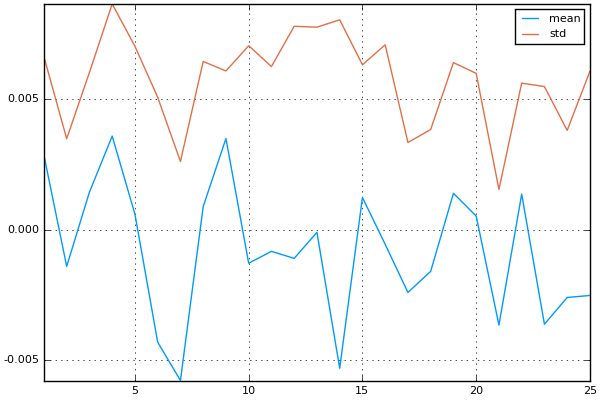

In [35]:
# plot mean and std
plot([ [mean(c2[:,i]) for i in 1:25] [std(c2[:,i]) for i in 1:25] ], legend=true, label=["mean" "std"])


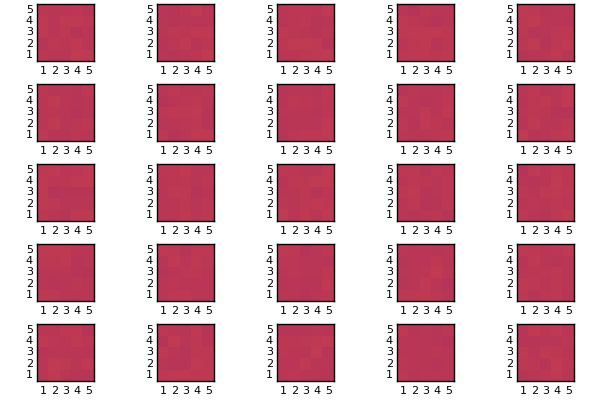

In [36]:
# plot them as 5x5 arrays
plot([heatmap(c2[:,:,1,i], aspect_ratio=:equal, legend=false, clims=(-0.4,0.4)) for i=1:25]...)

In [37]:
# run 18 more epochs
@time mx.fit(model, optimizer, train_provider, eval_data=eval_provider, n_epoch=18)

INFO: Start training on MXNet.mx.Context[CPU0]
INFO: Initializing parameters...
INFO: Creating KVStore...
INFO: TempSpace: Total 69 MB allocated on CPU0
INFO: Start training...
INFO: == Epoch 001/018 ==========
INFO: ## Training summary
INFO:           accuracy = 0.1098
INFO:               time = 34.8010 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.1056
INFO: == Epoch 002/018 ==========
INFO: ## Training summary
INFO:           accuracy = 0.1098
INFO:               time = 34.4926 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.1056
INFO: == Epoch 003/018 ==========
INFO: ## Training summary
INFO:           accuracy = 0.1006
INFO:               time = 34.7834 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.1056
INFO: == Epoch 004/018 ==========
INFO: ## Training summary
INFO:           accuracy = 0.1553
INFO:               time = 34.6748 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.2892
INFO: == Epoch 005/018 ====

In [38]:
# let's reexamine the weights conv1
c119 = copy(model.arg_params[:conv1_weight])

5×5×1×12 Array{Float32,4}:
[:, :, 1, 1] =
 0.347087  0.504456  0.567737  0.538973  0.432425
 0.393903  0.523908  0.569779  0.528236  0.497999
 0.395125  0.525169  0.554936  0.499069  0.412634
 0.409817  0.52002   0.507051  0.414124  0.273322
 0.381741  0.469218  0.429185  0.306862  0.100841

[:, :, 1, 2] =
  0.323644     0.118389  -0.0026643  -0.0229311   0.0765911
  0.312008    -0.055202  -0.196744   -0.240407   -0.157021 
  0.146242    -0.190073  -0.302505   -0.384476   -0.325627 
  0.00824947  -0.29817   -0.357419   -0.333338   -0.209352 
 -0.0523181   -0.427836  -0.403952   -0.229494   -0.0168368

[:, :, 1, 3] =
 0.261413  0.436814  0.504006  0.434034  0.216393 
 0.328354  0.490505  0.543335  0.489687  0.324578 
 0.344704  0.515091  0.542656  0.499094  0.318708 
 0.363087  0.511334  0.497447  0.413427  0.180996 
 0.380948  0.494009  0.448707  0.304783  0.0395302

...

[:, :, 1, 10] =
 0.220276  0.318692  0.398149  0.397225  0.383143
 0.284899  0.397029  0.440684  0.445467  0.404225

In [39]:
# get the extrema mean and standard deviation for each of the groups
[ [extrema(c119[:,:,1,i]) for i in 1:12] [mean(c119[:,:,1,i]) for i in 1:12] [std(c119[:,:,1,i]) for i in 1:12] ]

12×3 Array{Any,2}:
 (0.100841,0.569779)     0.444145   0.10797  
 (-0.427836,0.323644)   -0.12885    0.214875 
 (0.0395302,0.543335)    0.395346   0.127208 
 (0.169595,0.385928)     0.315322   0.0566515
 (-0.294483,0.321728)    0.053916   0.181087 
 (-0.390924,-0.203199)  -0.337491   0.0501928
 (-0.437431,0.303169)   -0.114155   0.212691 
 (-0.462075,0.416577)    0.0910027  0.224481 
 (-0.19899,0.472883)     0.260703   0.170743 
 (0.220276,0.473572)     0.387915   0.0642632
 (-0.155241,0.290511)    0.0440151  0.150919 
 (0.2069,0.444287)       0.359418   0.060294 

In [40]:
# let's also get the extrema mean and standard deviation for all
[ extrema(c119[:,:,1,:]) mean(c119[:,:,1,:]) std(c119[:,:,1,:]) ]

1×3 Array{Any,2}:
 (-0.462075,0.569779)  0.147607  0.282275


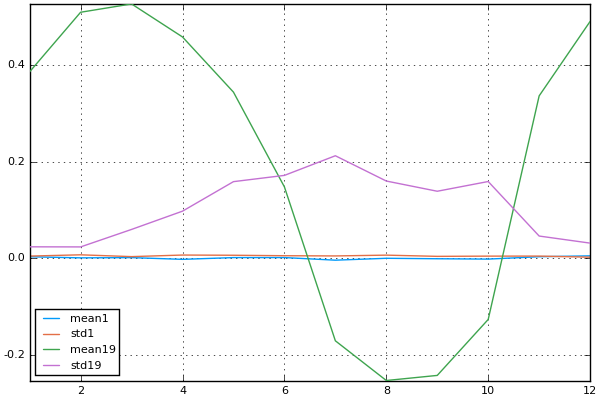

In [41]:
# plot mean and std
plot([ [mean(c1[:,i]) for i in 1:12] [std(c1[:,i]) for i in 1:12]  [mean(c119[:,i]) for i in 1:12] [std(c119[:,i]) for i in 1:12] ],
legend=true, label=["mean1" "std1" "mean19" "std19"])


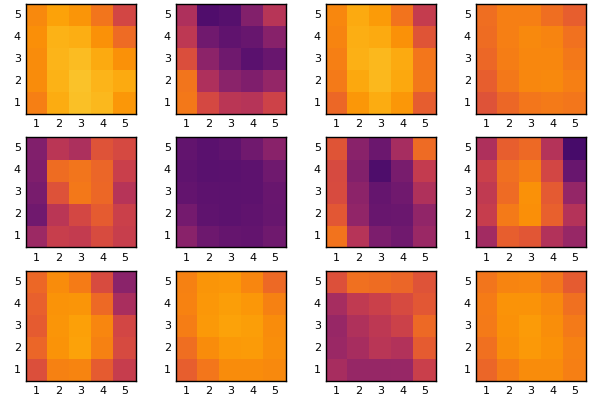

In [42]:
# plot them as 5x5 arrays
plot([heatmap(c119[:,:,1,i], aspect_ratio=:equal, legend=false, clims=(-0.8,0.8)) for i=1:12]...)

In [43]:
# let's examine the weights conv2 as well
c219 = copy(model.arg_params[:conv2_weight])

5×5×12×25 Array{Float32,4}:
[:, :, 1, 1] =
 -0.0364719   -0.00877716  -0.0237755   0.0123821  0.0068629
 -0.0274578    0.0196342   -0.00774219  0.0328067  0.0559874
 -0.0166751   -0.0447344   -0.0523402   0.0329785  0.0876038
 -0.00647348  -0.114211    -0.0437252   0.039249   0.0793428
 -0.0735974   -0.153939    -0.0719378   0.0120264  0.0496703

[:, :, 2, 1] =
 0.0419839  0.041832    0.00287022  -0.0594714  -0.0541494
 0.0519522  0.108765   -0.00783979  -0.078845   -0.0785254
 0.0196331  0.0603161   0.00954297  -0.0953302  -0.135092 
 0.0465909  0.126507    0.110917    -0.0896359  -0.120481 
 0.0573112  0.118045    0.0436562   -0.0456115  -0.0574438

[:, :, 3, 1] =
 -0.037973   -0.0107786   -0.0105543   0.0134816   -0.00707869
 -0.0129707  -0.00916309  -0.0185991   0.0140442    0.0546557 
 -0.0375171  -0.0502023   -0.0780698   0.0321535    0.0997039 
 -0.0377794  -0.145896    -0.0543796   0.014113     0.0793427 
 -0.0996124  -0.153437    -0.0882263  -0.00652718   0.065371  

...

[:, 

In [44]:
# let's get the extrema mean and standard deviation for each of the 25 groups
[ [extrema(c219[:,:,1,i]) for i in 1:25] [mean(c219[:,:,1,i]) for i in 1:25] [std(c219[:,:,1,i]) for i in 1:25] ]

25×3 Array{Any,2}:
 (-0.153939,0.0876038)   -0.0101326   0.0572027
 (-0.118426,0.0955442)    0.0213693   0.0561439
 (-0.491816,-0.30411)    -0.384194    0.047708 
 (-0.270727,-0.0246904)  -0.110264    0.0676549
 (-0.157246,0.08228)     -0.0445763   0.0692361
 (-0.158817,-0.0113069)  -0.0745692   0.0417024
 (-0.0218627,0.180069)    0.109227    0.0507255
 (-0.0275593,0.244164)    0.140628    0.0711413
 (-0.171613,0.0558899)   -0.0352489   0.0611548
 (-0.183026,0.12864)      0.0179071   0.0839397
 (0.0100492,0.164816)     0.108476    0.0432815
 (-0.132239,0.106487)    -0.0173583   0.0672549
 (-0.146827,0.130302)     0.0154912   0.0671512
 (0.001018,0.183979)      0.101385    0.0546818
 (-0.132433,0.0990523)   -0.0106877   0.0693795
 (-0.141182,0.100734)    -0.0223909   0.0744164
 (-0.121269,0.112141)     0.0243037   0.0682564
 (-0.0863334,0.128516)   -0.00144645  0.0517144
 (-0.0926517,0.0756372)   0.00270758  0.050734 
 (-0.172718,0.0187184)   -0.068073    0.0487715
 (-0.128551,0.103839)

In [45]:
# get total extrema, mean and standard deviation
[ extrema(c219[:,:,1,:]) mean(c219[:,:,1,:]) std(c219[:,:,1,:]) ]

1×3 Array{Any,2}:
 (-0.491816,0.244164)  -0.017453  0.122143


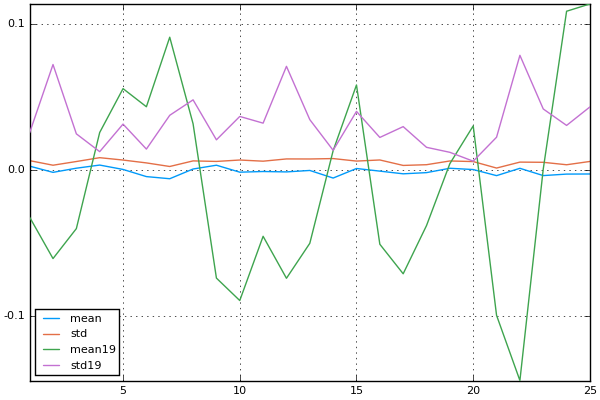

In [46]:
# plot mean and std
plot([ [mean(c2[:,i]) for i in 1:25] [std(c2[:,i]) for i in 1:25] [mean(c219[:,i]) for i in 1:25] [std(c219[:,i]) for i in 1:25] ], 
legend=true, label=["mean" "std" "mean19" "std19"])


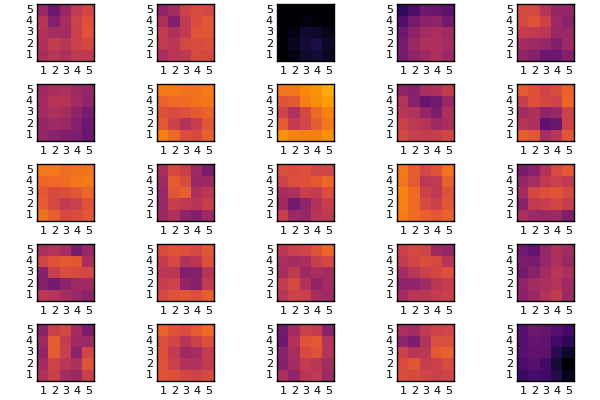

In [47]:
# plot them as 5x5 arrays
plot([heatmap(c219[:,:,1,i], aspect_ratio=:equal, legend=false, clims=(-0.4,0.4)) for i=1:25]...)

# Run on test set

In [48]:
@time test = readtable("data/test.csv");

  7.624789 seconds (21.56 M allocations: 810.821 MB, 8.28% gc time)


In [49]:
# use same transform as used on training set
test_X = transpose(Array(test))
test_X = (test_X./80).-0.4176
test_X = reshape(test_X, 28,28,1,size(test_X)[2])

28×28×1×28000 Array{Float64,4}:
[:, :, 1, 1] =
 -0.4176  -0.4176  -0.4176  -0.4176  …  -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176  …  -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176  …  -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4176  -0.4176  -0.4176
 -0.4176  -0.4176  -0.4176  -0.4176     -0.4176  -0.4

In [50]:
test_provider = mx.ArrayDataProvider(test_X, batch_size=batch_size, shuffle=false)

MXNet.mx.ArrayDataProvider(Array{Float32,N}[
Float32[-0.4176 -0.4176 … -0.4176 -0.4176; -0.4176 -0.4176 … -0.4176 -0.4176; … ; -0.4176 -0.4176 … -0.4176 -0.4176; -0.4176 -0.4176 … -0.4176 -0.4176]],Symbol[:data],Array{Float32,N}[],Symbol[],1000,28000,false,0.0f0,0.0f0,MXNet.mx.NDArray[mx.NDArray{Float32}(28,28,1,1000)],MXNet.mx.NDArray[])

In [51]:
tpreds = mx.predict(model, test_provider)

INFO: TempSpace: Total 33 MB allocated on CPU0


10×28000 Array{Float32,2}:
 8.94318f-6   0.98604      1.23295f-5   …  2.23896f-5   3.70835f-5 
 1.47187f-6   1.41147f-5   1.64901f-5      3.05115f-6   1.95721f-6 
 0.999183     0.000973534  8.24564f-6      2.00543f-7   0.996558   
 0.000730518  0.000354414  0.000366491     0.000242505  0.0031445  
 4.66439f-8   4.51539f-7   0.00142626      0.000838235  1.45716f-7 
 9.0476f-7    0.0116142    0.000268574  …  0.000442273  1.54422f-6 
 9.3788f-8    0.000470154  1.80571f-7      1.01009f-7   6.16412f-8 
 3.69469f-5   0.000105516  4.54483f-5      0.000990315  3.44919f-5 
 3.64188f-5   9.67727f-5   0.0588671       0.000329384  0.000212094
 1.28144f-6   0.000330537  0.938989        0.997131     1.00957f-5 

In [52]:
# create submission
open("LeNetsubmission.csv", "w") do f
    write(f, "ImageId,Label\n")
    for i = 1:size(tpreds)[2]
        write(f, string(i),",",string(indmax(tpreds[:,i])-1),"\n")
    end
end

In [53]:
# submit to https://kaggle.com/c/digit-recognizer/submit
# got score of 0.97257 on test set

[<img style="float: left;" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png">](http://creativecommons.org/licenses/by-sa/4.0/)  

Licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).